<a href="https://colab.research.google.com/github/rafayhabibullah/Qunat-Analysis/blob/master/BTC_SIP_with_multiple_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loaded: 1826 rows

=== FINAL SUMMARY ===
              total_invested_usd  final_btc  last_price_usd  \
Basic_DCA                 3652.0   0.097615     107154.5625   
MA_Based                  3788.0   0.115183     107154.5625   
Dip_Buy                   3822.0   0.102130     107154.5625   
RSI_Adjusted              3833.0   0.104158     107154.5625   
Hybrid                    5354.0   0.154153     107154.5625   

              portfolio_value_usd  avg_buy_price_usd_per_btc     roi_pct  \
Basic_DCA            10459.939290               37412.116019  186.416738   
MA_Based             12342.390515               32886.780098  225.828683   
Dip_Buy              10943.649530               37423.049483  186.333059   
RSI_Adjusted         11160.997687               36799.885601  191.181782   
Hybrid               16518.217990               34731.684010  208.521068   

              days_invested  
Basic_DCA            1826.0  
MA_Based             1826.0  
Dip_Buy              1826.0 

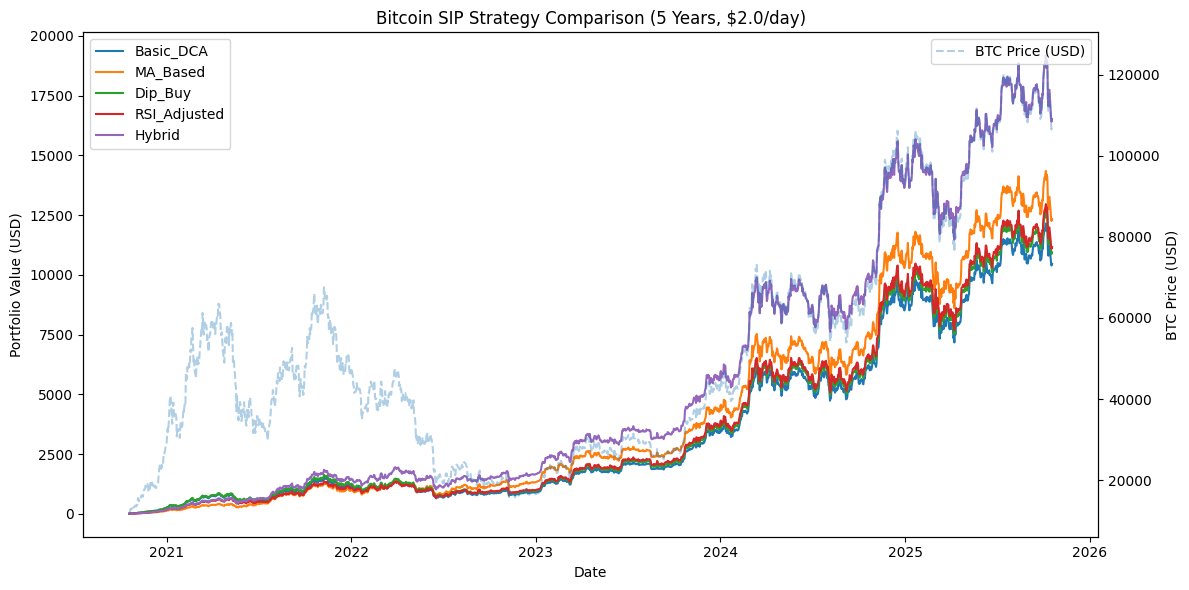

In [1]:
# -------------------------
# BTC SIP Backtest (5 Years, 5 Strategies)
# -------------------------

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

# -------------------------
# PARAMETERS
# -------------------------
base_daily_usd = 2.0
period_years = 5
end_date = datetime.now(timezone.utc).date()
start_date = end_date - timedelta(days=365 * period_years)
ticker = "BTC-USD"

save_csv = "btc_sip_summary.csv"
save_png = "btc_sip_chart.png"

# -------------------------
# HELPER FUNCTIONS
# -------------------------
def to_float(x):
    """Safely convert scalars or 1-element Series/arrays to float."""
    if isinstance(x, pd.Series):
        if len(x) > 0:
            return float(x.iloc[0])
        else:
            return np.nan
    elif isinstance(x, (np.ndarray, list)):
        if len(x) > 0:
            return float(x[0])
        else:
            return np.nan
    try:
        return float(x)
    except Exception:
        return np.nan

def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(period, min_periods=1).mean()
    ma_down = down.rolling(period, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

# -------------------------
# FETCH DATA
# -------------------------
print(f"Downloading {ticker} data...")
df = yf.download(
    ticker,
    start=start_date.strftime("%Y-%m-%d"),
    end=(end_date + timedelta(days=1)).strftime("%Y-%m-%d"),
    progress=False,
    auto_adjust=False
)

df = df[["Close"]].rename(columns={"Close": "close"})
df.index = pd.to_datetime(df.index).date
df = df.sort_index()
print(f"Data loaded: {len(df)} rows")

# -------------------------
# CALCULATE INDICATORS
# -------------------------
df["ma200"] = df["close"].rolling(window=200, min_periods=1).mean()
df["rsi14"] = rsi(df["close"], period=14)
df["daily_pct"] = df["close"].pct_change() * 100

# -------------------------
# BUY STRATEGIES
# -------------------------
def buy_basic(date, row, df_all):
    return base_daily_usd

def buy_ma(date, row, df_all):
    close = to_float(row["close"])
    ma200 = to_float(row["ma200"])
    if np.isnan(ma200):
        ma200 = close  # fallback to prevent skipping
    return base_daily_usd * (2.0 if close < ma200 else 0.5)

def buy_dip(date, row, df_all):
    daily_pct = to_float(row["daily_pct"])
    return base_daily_usd * 2.0 if not np.isnan(daily_pct) and daily_pct <= -5 else base_daily_usd

def buy_rsi(date, row, df_all):
    rsi_val = to_float(row["rsi14"])
    if np.isnan(rsi_val):
        rsi_val = 50  # neutral fallback
    if rsi_val < 35:
        return base_daily_usd * 2.0
    elif rsi_val > 70:
        return base_daily_usd * 0.5
    return base_daily_usd

def buy_hybrid(date, row, df_all):
    close = to_float(row["close"])
    ma200 = to_float(row["ma200"])
    rsi_val = to_float(row["rsi14"])
    daily_pct = to_float(row["daily_pct"])
    usd = base_daily_usd
    add_mult = 0.0

    # fallback values for early rows
    if np.isnan(ma200): ma200 = close
    if np.isnan(rsi_val): rsi_val = 50
    if np.isnan(daily_pct): daily_pct = 0

    if close < ma200: add_mult += 1.0
    if rsi_val < 35: add_mult += 1.0
    if daily_pct <= -5: add_mult += 1.0

    usd = usd * (1 + add_mult)

    # reduce when overbought
    if rsi_val > 70 and close > ma200:
        usd = base_daily_usd * 0.5

    return usd

# -------------------------
# SIMULATOR
# -------------------------
def simulate_strategy(df, buy_rule_fn):
    df2 = df.copy()
    df2["usd_invested"] = 0.0
    df2["btc_bought"] = 0.0

    for d, row in df2.iterrows():
        usd = to_float(buy_rule_fn(d, row, df2))
        price = to_float(row["close"])

        if np.isnan(price) or price <= 0 or usd <= 0:
            df2.at[d, "usd_invested"] = 0.0
            df2.at[d, "btc_bought"] = 0.0
            continue

        btc = usd / price
        df2.at[d, "usd_invested"] = usd
        df2.at[d, "btc_bought"] = btc

    df2["cum_usd"] = df2["usd_invested"].cumsum()
    df2["cum_btc"] = df2["btc_bought"].cumsum()

    last_price = to_float(df2["close"].iloc[-1])
    final_btc = to_float(df2["cum_btc"].iloc[-1])
    total_invested = to_float(df2["cum_usd"].iloc[-1])
    portfolio_value = final_btc * last_price
    avg_buy_price = total_invested / final_btc if final_btc > 0 else np.nan
    roi_pct = (portfolio_value - total_invested) / total_invested * 100 if total_invested > 0 else np.nan

    stats = {
        "total_invested_usd": total_invested,
        "final_btc": final_btc,
        "last_price_usd": last_price,
        "portfolio_value_usd": portfolio_value,
        "avg_buy_price_usd_per_btc": avg_buy_price,
        "roi_pct": roi_pct,
        "days_invested": int((df2["usd_invested"] > 0).sum())
    }
    return df2, stats

# -------------------------
# RUN STRATEGIES
# -------------------------
strategies = {
    "Basic_DCA": buy_basic,
    "MA_Based": buy_ma,
    "Dip_Buy": buy_dip,
    "RSI_Adjusted": buy_rsi,
    "Hybrid": buy_hybrid
}

results = {}
frames = {}

for name, fn in strategies.items():
    frame, stats = simulate_strategy(df, fn)
    results[name] = stats
    frames[name] = frame

# -------------------------
# SUMMARY
# -------------------------
summary = pd.DataFrame(results).T
summary = summary[[
    "total_invested_usd",
    "final_btc",
    "last_price_usd",
    "portfolio_value_usd",
    "avg_buy_price_usd_per_btc",
    "roi_pct",
    "days_invested"
]]
summary.to_csv(save_csv)
print("\n=== FINAL SUMMARY ===")
print(summary)

# -------------------------
# PLOT RESULTS
# -------------------------
plt.figure(figsize=(12, 6))
for name, frame in frames.items():
    frame = frame.copy()
    frame["port_value"] = frame["cum_btc"].to_numpy().ravel() * frame["close"].to_numpy().ravel()
    plt.plot(frame.index, frame["port_value"], label=name)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df.index, df["close"], "--", alpha=0.35, label="BTC Price (USD)")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value (USD)")
ax2.set_ylabel("BTC Price (USD)")
ax.set_title(f"Bitcoin SIP Strategy Comparison ({period_years} Years, ${base_daily_usd}/day)")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.savefig(save_png, dpi=150)
plt.show()
